# Setup

In [1]:
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import *
from statsmodels.tsa.stattools import adfuller, coint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
from fredapi import Fred

In [2]:
load_dotenv()
api_key = os.getenv("FRED_API_KEY")
fred = Fred(api_key=api_key)

# Gather data

In [3]:
# Pull data only until BEA update from Q2 2025. This is for reproducibility in the future.
cutoff_date = "2025-04-01"

<Axes: >

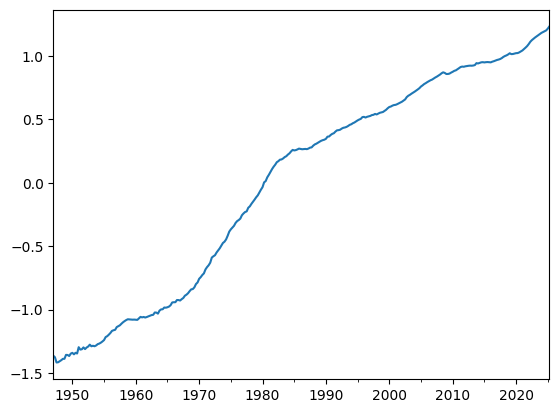

In [4]:
gov = fred.get_series('B823RG3Q086SBEA')[:cutoff_date]
gov = np.log(gov)
gov = (gov - gov.mean())
gov.name = "gov"
gov.plot()

<Axes: >

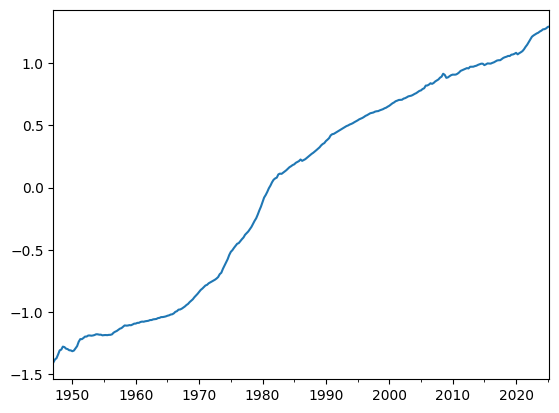

In [5]:
cpi = fred.get_series('CPIAUCSL')[:cutoff_date]
cpi = np.log(cpi)
cpi = cpi[cpi.index.month.isin([1,4,7,10])] # to quarterly, with months aligning with the NIPA dates
cpi = (cpi - cpi.mean())
cpi.name = "cpi"
cpi.plot()

<Axes: >

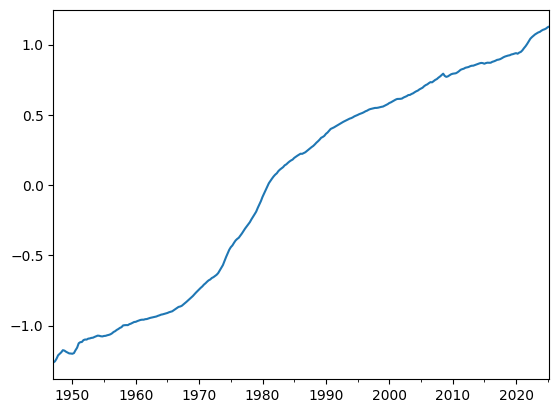

In [6]:
pce = fred.get_series('PCECTPI')[:cutoff_date]
pce = np.log(pce)
pce = (pce - pce.mean())
pce.name = "pce"
pce.plot()

<Axes: >

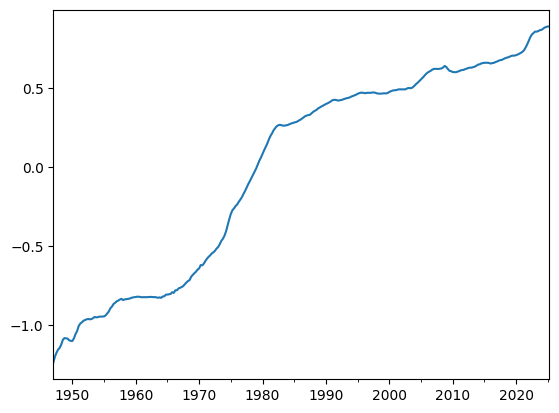

In [7]:
inv = fred.get_series('B007RG3Q086SBEA')[:cutoff_date]
inv = np.log(inv)
inv = (inv - inv.mean())
inv.name = "inv"
inv.plot()

In [8]:
data_all = pd.concat([gov,cpi,pce,inv], axis=1)
data_all = data_all.dropna()
data_all

,gov,cpi,pce,inv
1947-01-01,-1.363063,-1.406892,-1.262188,-1.236221
1947-04-01,-1.374820,-1.382972,-1.254259,-1.199238
1947-07-01,-1.416057,-1.372572,-1.235802,-1.174539
1947-10-01,-1.414422,-1.342441,-1.211163,-1.154216
1948-01-01,-1.406289,-1.309384,-1.200124,-1.144330
...,...,...,...,...
2024-04-01,1.186985,1.272240,1.104939,0.872477
2024-07-01,1.193031,1.273995,1.108760,0.880342
2024-10-01,1.199608,1.280347,1.114650,0.884239
2025-01-01,1.213412,1.291446,1.123631,0.887275


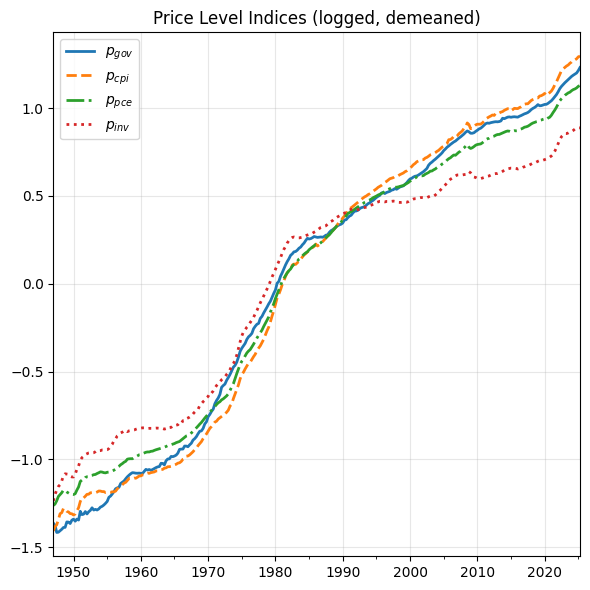

In [9]:
df = data_all.copy()
df.columns = [r'$p_{gov}$', r'$p_{cpi}$', r'$p_{pce}$', r'$p_{inv}$']  # Adjust as needed

# Simple, clean plot
df.plot(
    figsize=(6, 6), 
     style=['-', '--', '-.', ':'],
    linewidth=2)
plt.title('Price Level Indices (logged, demeaned)')
plt.grid(alpha=0.3)
plt.tight_layout()
# plt.savefig('variable levels.png', bbox_inches='tight')

In [10]:
data_cpi = pd.concat([gov,cpi], axis=1)
data_cpi = data_cpi.dropna()
data_cpi

,gov,cpi
1947-01-01,-1.363063,-1.406892
1947-04-01,-1.374820,-1.382972
1947-07-01,-1.416057,-1.372572
1947-10-01,-1.414422,-1.342441
1948-01-01,-1.406289,-1.309384
...,...,...
2024-04-01,1.186985,1.272240
2024-07-01,1.193031,1.273995
2024-10-01,1.199608,1.280347
2025-01-01,1.213412,1.291446


<Axes: >

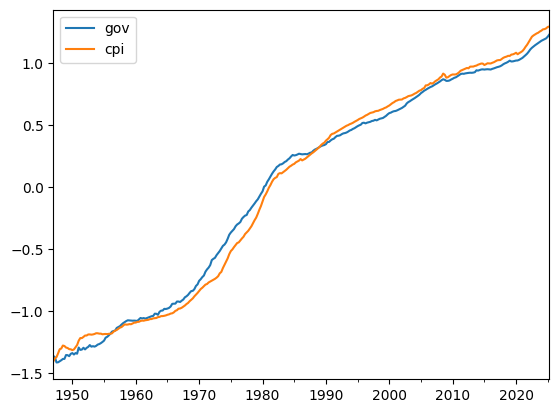

In [11]:
data_cpi.plot()

In [42]:
# write to file
# data_cpi.to_csv("cpi.csv")

In [12]:
data_nipa = pd.concat([gov,pce,inv], axis=1)
data_nipa = data_nipa.dropna()
data_nipa

,gov,pce,inv
1947-01-01,-1.363063,-1.262188,-1.236221
1947-04-01,-1.374820,-1.254259,-1.199238
1947-07-01,-1.416057,-1.235802,-1.174539
1947-10-01,-1.414422,-1.211163,-1.154216
1948-01-01,-1.406289,-1.200124,-1.144330
...,...,...,...
2024-04-01,1.186985,1.104939,0.872477
2024-07-01,1.193031,1.108760,0.880342
2024-10-01,1.199608,1.114650,0.884239
2025-01-01,1.213412,1.123631,0.887275


<Axes: >

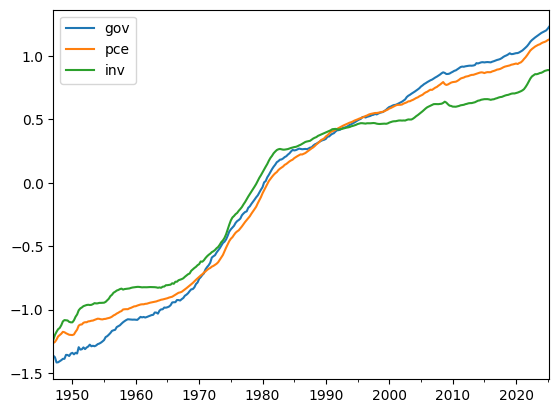

In [13]:
data_nipa.plot()

In [45]:
# Write data to file
# data_nipa.to_csv("nipa.csv")

# Unit Root tests

In [ ]:
def adf_test(timeseries,**kwargs):
    # adapted from https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html#Stationarity-and-detrending-(ADF/KPSS)
    # print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="BIC", **kwargs)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Number of Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    return dfoutput

In [ ]:
tex = pd.concat([adf_test(data_all["gov"]),adf_test(data_all["cpi"]),adf_test(data_all["pce"]),adf_test(data_all["inv"])],axis=1).to_latex(header=["gov","cpi","pce","inv"], float_format="%.3f")
tex = tex.replace("%","\\%")
# the next 2 lines are from ChatGPT, they're for bolding the p-value row.
import re
tex = re.sub(r"(p-value\s*&.*?\\\\)", lambda m: re.sub(r"([^&\\\\]+)", r"\\textbf{\1}", m.group(1)), tex)
caption = "Augmented Dickey-Fuller tests for unit root, on level variables. High p-values indicate that the series are non-stationary. Lags are selected with the Bayesian Information Criterion."
label = "adf1"
print(
    "\\begin{table}\n"
    + "\\centering\n"
    + tex[:tex.find(r"\end{table}")] 
    + "\n\\caption{" + caption + "}" 
    + "\n\\label{" + label + "}"
    + "\n\\end{table}")


\begin{table}
\centering
\begin{tabular}{lrrrr}
\toprule
 & gov & cpi & pce & inv \\
\midrule
Test Statistic & -1.399 & -0.266 & -0.351 & -1.043 \\
\textbf{p-value }&\textbf{ 0.583 }&\textbf{ 0.930 }&\textbf{ 0.918 }&\textbf{ 0.737 }\\
Number of Lags Used & 4.000 & 3.000 & 3.000 & 2.000 \\
Number of Observations Used & 309.000 & 310.000 & 310.000 & 311.000 \\
Critical Value (1\%) & -3.452 & -3.452 & -3.452 & -3.452 \\
Critical Value (5\%) & -2.871 & -2.871 & -2.871 & -2.871 \\
Critical Value (10\%) & -2.572 & -2.572 & -2.572 & -2.572 \\
\bottomrule
\end{tabular}
\caption{Augmented Dickey-Fuller tests for unit root, on level variables. High p-values indicate that the series are non-stationary. Lags are selected with the Bayesian Information Criterion.}
\label{adf1}
\end{table}


In [ ]:
tex = pd.concat([adf_test(data_all["gov"].diff().dropna()),adf_test(data_all["cpi"].diff().dropna()),adf_test(data_all["pce"].diff().dropna()),adf_test(data_all["inv"].diff().dropna())],axis=1).to_latex(header=["gov","cpi","pce","inv"], float_format="%.3f")
tex = tex.replace("%","\\%")
# the next 2 lines are from ChatGPT, they're for bolding the p-value row.
import re
tex = re.sub(r"(p-value\s*&.*?\\\\)", lambda m: re.sub(r"([^&\\\\]+)", r"\\textbf{\1}", m.group(1)), tex)
caption = "Augmented Dickey-Fuller tests for unit root, on differenced variables. Low p-values indicate that the series are stationary after differencing. Lags are selected with the Bayesian Information Criterion."
label = "adf2"
print(
    "\\begin{table}\n"
    + "\\centering\n"
    + tex[:tex.find(r"\end{table}")] 
    + "\n\\caption{" + caption + "}" 
    + "\n\\label{" + label + "}"
    + "\n\\end{table}")

\begin{table}
\centering
\begin{tabular}{lrrrr}
\toprule
 & gov & cpi & pce & inv \\
\midrule
Test Statistic & -4.678 & -4.732 & -4.445 & -4.908 \\
\textbf{p-value }&\textbf{ 0.000 }&\textbf{ 0.000 }&\textbf{ 0.000 }&\textbf{ 0.000 }\\
Number of Lags Used & 3.000 & 2.000 & 2.000 & 1.000 \\
Number of Observations Used & 309.000 & 310.000 & 310.000 & 311.000 \\
Critical Value (1\%) & -3.452 & -3.452 & -3.452 & -3.452 \\
Critical Value (5\%) & -2.871 & -2.871 & -2.871 & -2.871 \\
Critical Value (10\%) & -2.572 & -2.572 & -2.572 & -2.572 \\
\bottomrule
\end{tabular}
\caption{Augmented Dickey-Fuller tests for unit root, on differenced variables. Low p-values indicate that the series are stationary after differencing. Lags are selected with the Bayesian Information Criterion.}
\label{adf2}
\end{table}


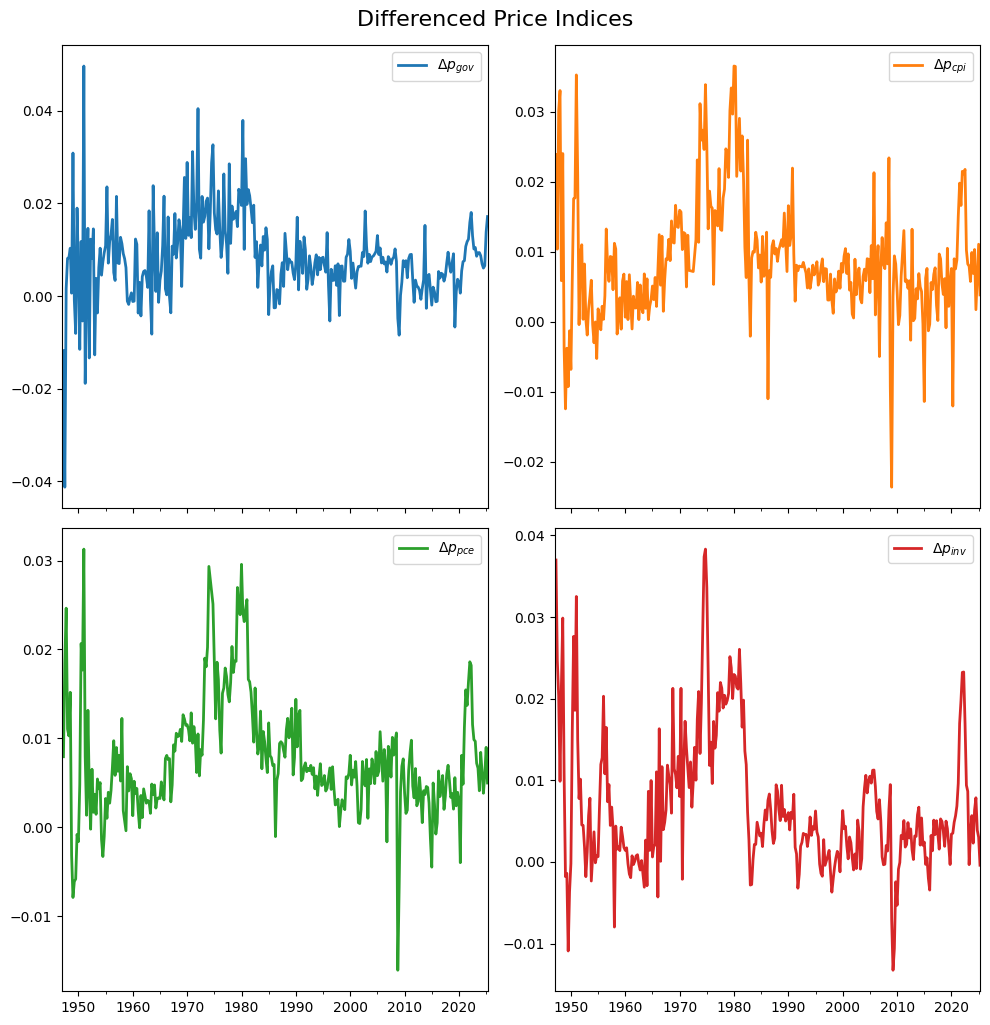

In [ ]:
df = pd.concat([gov,cpi,pce,inv], axis=1).dropna().diff()
df.columns = [r'$\Delta p_{gov}$', r'$\Delta p_{cpi}$', r'$\Delta p_{pce}$', r'$\Delta p_{inv}$']  # Adjust as needed

# Simple, clean plot
df.plot(subplots=True, figsize=(10, 10), linewidth=2, layout=(2,2))
plt.tight_layout()
plt.suptitle('Differenced Price Indices', fontsize=16,y=1.02) 
plt.savefig('variable differences.png', bbox_inches='tight')

# Select lags

In [ ]:
print(VAR(data_cpi).select_order().summary())
# Need to subtract 1 to get the lags for the VECM

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -5.835      -5.810    0.002924      -5.825
1       -19.90      -19.83   2.267e-09      -19.87
2       -20.23      -20.11   1.637e-09      -20.18
3       -20.26      -20.09   1.586e-09      -20.19
4       -20.35     -20.13*   1.452e-09     -20.26*
5       -20.37      -20.09   1.429e-09      -20.26
6      -20.37*      -20.05  1.421e-09*      -20.24
7       -20.35      -19.98   1.451e-09      -20.20
8       -20.34      -19.92   1.464e-09      -20.17
9       -20.36      -19.89   1.432e-09      -20.18
10      -20.35      -19.83   1.458e-09      -20.14
11      -20.33      -19.76   1.476e-09      -20.11
12      -20.33      -19.70   1.490e-09      -20.08
13      -20.33      -19.66   1.484e-09      -20.06
14      -20.31      -19.59   1.512e-09      -20.02
15      -20.30      -19.53   1.529e-09      -19.99
16      -20.28      -19.46   1.

c:\Users\sam.levey\Documents\Research\Monopoly money empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [ ]:
# latex version of above table
from io import StringIO
df = pd.read_csv(StringIO(VAR(data_cpi).select_order().summary().as_csv().split('\n', 1)[1]))
df.columns = ["Lags", *df.columns[1:]]
tex = df.to_latex(index=False)
caption = "VAR Order Selection for GOV/CPI Model (* indicates the minimums)."
label = "lag1"
print(
    "\\begin{table}\n"
    + "\\centering\n"
    + tex[:tex.find(r"\end{table}")] 
    + "\n\\caption{" + caption + "}" 
    + "\n\\label{" + label + "}"
    + "\n\\end{table}")

\begin{table}
\centering
\begin{tabular}{rllll}
\toprule
Lags &     AIC     &     BIC     &     FPE     &     HQIC    \\
\midrule
0 &     -5.835  &     -5.810  &   0.002924  &     -5.825  \\
1 &     -19.90  &     -19.83  &  2.267e-09  &     -19.87  \\
2 &     -20.23  &     -20.11  &  1.637e-09  &     -20.18  \\
3 &     -20.26  &     -20.09  &  1.586e-09  &     -20.19  \\
4 &     -20.35  &     -20.13* &  1.452e-09  &     -20.26* \\
5 &     -20.37  &     -20.09  &  1.429e-09  &     -20.26  \\
6 &     -20.37* &     -20.05  &  1.421e-09* &     -20.24  \\
7 &     -20.35  &     -19.98  &  1.451e-09  &     -20.20  \\
8 &     -20.34  &     -19.92  &  1.464e-09  &     -20.17  \\
9 &     -20.36  &     -19.89  &  1.432e-09  &     -20.18  \\
10 &     -20.35  &     -19.83  &  1.458e-09  &     -20.14  \\
11 &     -20.33  &     -19.76  &  1.476e-09  &     -20.11  \\
12 &     -20.33  &     -19.70  &  1.490e-09  &     -20.08  \\
13 &     -20.33  &     -19.66  &  1.484e-09  &     -20.06  \\
14 &     -20

c:\Users\sam.levey\Documents\Research\Monopoly money empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [ ]:
print(VAR(data_nipa).select_order().summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -11.81      -11.77   7.462e-06      -11.79
1       -31.30      -31.15   2.555e-14      -31.24
2       -32.31     -32.05*   9.253e-15      -32.21
3       -32.41      -32.04   8.400e-15     -32.26*
4       -32.45      -31.97   8.082e-15      -32.26
5      -32.48*      -31.89  7.831e-15*      -32.24
6       -32.45      -31.74   8.065e-15      -32.17
7       -32.42      -31.60   8.332e-15      -32.09
8       -32.43      -31.50   8.254e-15      -32.06
9       -32.42      -31.38   8.316e-15      -32.01
10      -32.42      -31.27   8.302e-15      -31.96
11      -32.41      -31.15   8.416e-15      -31.91
12      -32.48      -31.10   7.887e-15      -31.93
13      -32.44      -30.95   8.187e-15      -31.85
14      -32.46      -30.86   8.080e-15      -31.81
15      -32.42      -30.71   8.368e-15      -31.74
16      -32.40      -30.58   8.

c:\Users\sam.levey\Documents\Research\Monopoly money empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [ ]:
# latex version of above table
from io import StringIO
df = pd.read_csv(StringIO(VAR(data_nipa).select_order().summary().as_csv().split('\n', 1)[1]))
df.columns = ["Lags", *df.columns[1:]]
tex = df.to_latex(index=False)
caption = "VAR Order Selection for NIPA Model (* indicates the minimums)."
label = "lag2"
print(
    "\\begin{table}\n"
    + "\\centering\n"
    + tex[:tex.find(r"\end{table}")] 
    + "\n\\caption{" + caption + "}" 
    + "\n\\label{" + label + "}"
    + "\n\\end{table}")

\begin{table}
\centering
\begin{tabular}{rllll}
\toprule
Lags &     AIC     &     BIC     &     FPE     &     HQIC    \\
\midrule
0 &     -11.81  &     -11.77  &  7.462e-06  &     -11.79  \\
1 &     -31.30  &     -31.15  &  2.555e-14  &     -31.24  \\
2 &     -32.31  &     -32.05* &  9.253e-15  &     -32.21  \\
3 &     -32.41  &     -32.04  &  8.400e-15  &     -32.26* \\
4 &     -32.45  &     -31.97  &  8.082e-15  &     -32.26  \\
5 &     -32.48* &     -31.89  &  7.831e-15* &     -32.24  \\
6 &     -32.45  &     -31.74  &  8.065e-15  &     -32.17  \\
7 &     -32.42  &     -31.60  &  8.332e-15  &     -32.09  \\
8 &     -32.43  &     -31.50  &  8.254e-15  &     -32.06  \\
9 &     -32.42  &     -31.38  &  8.316e-15  &     -32.01  \\
10 &     -32.42  &     -31.27  &  8.302e-15  &     -31.96  \\
11 &     -32.41  &     -31.15  &  8.416e-15  &     -31.91  \\
12 &     -32.48  &     -31.10  &  7.887e-15  &     -31.93  \\
13 &     -32.44  &     -30.95  &  8.187e-15  &     -31.85  \\
14 &     -32

c:\Users\sam.levey\Documents\Research\Monopoly money empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


# Cointegration tests

## Engle-Granger test

In [41]:
# EG test. We can do this because there are only two variales.
result = coint(data_cpi["gov"],data_cpi["cpi"],"n")
tex = pd.Series({
    "Test Statistic":result[0],
    "p-value": result[1],
}).to_latex(header=["GOV/CPI model"],caption="Engle-Granger test for Cointegration",label="egtest",float_format="%.3f")
print(
    tex[:tex.find(r"\begin{tabular}")]
    + "\\centering\n"
    + tex[tex.find(r"\begin{tabular}"):]
)

\begin{table}
\caption{Engle-Granger test for Cointegration}
\label{egtest}
\centering
\begin{tabular}{lr}
\toprule
 & GOV/CPI model \\
\midrule
Test Statistic & -2.696 \\
p-value & 0.059 \\
\bottomrule
\end{tabular}
\end{table}



## Johansen test

In [ ]:
det_order = 0    # constant term
k_ar_diff = 5     # 5 lags for the differenced model
result_m1 = coint_johansen(data_cpi,det_order,k_ar_diff)
print("Johansen cointegration test")
print(pd.Series({
    "Trace statistics": result_m1.trace_stat,
    "Trace critical values1":result_m1.trace_stat_crit_vals[0],
    "Trace critical values2":result_m1.trace_stat_crit_vals[1],
    "Max eigenvalue statistics": result_m1.max_eig_stat,
    "Max eig critical values1":result_m1.max_eig_stat_crit_vals[0],
    "Max eig critical values2":result_m1.max_eig_stat_crit_vals[1]
}))


Johansen cointegration test
Trace statistics             [20.86357180290097, 4.41944889239868]
Trace critical values1                 [13.4294, 15.4943, 19.9349]
Trace critical values2                    [2.7055, 3.8415, 6.6349]
Max eigenvalue statistics    [16.44412291050229, 4.41944889239868]
Max eig critical values1                 [12.2971, 14.2639, 18.52]
Max eig critical values2                  [2.7055, 3.8415, 6.6349]
dtype: object


In [ ]:
det_order = 0    # constant term
k_ar_diff = 4     # 4 lags for the differenced model
result_m2 = coint_johansen(data_nipa,det_order,k_ar_diff)
print("Johansen cointegration test")
print(pd.Series({
    "Trace statistics": result_m2.lr1,
    "Trace critical values1":result_m2.cvt[0],
    "Trace critical values2":result_m2.cvt[1],
    "Max eigenvalue statistics": result_m2.lr2,
    "Max eig critical values1":result_m2.max_eig_stat_crit_vals[0],
    "Max eig critical values2":result_m2.max_eig_stat_crit_vals[1]
}))

Johansen cointegration test
Trace statistics             [56.86256326214437, 18.646969590484964, 0.5684...
Trace critical values1                             [27.0669, 29.7961, 35.4628]
Trace critical values2                             [13.4294, 15.4943, 19.9349]
Max eigenvalue statistics    [38.2155936716594, 18.078476170293854, 0.56849...
Max eig critical values1                            [18.8928, 21.1314, 25.865]
Max eig critical values2                             [12.2971, 14.2639, 18.52]
dtype: object


In [ ]:
result_cpi = pd.Series([
        "Constant",
        5,
        result_m1.lr1[0],
        *result_m1.cvt[0],
        result_m1.lr2[0],
        *result_m1.max_eig_stat_crit_vals[0],
        result_m1.lr1[1],
        *result_m1.cvt[1],
        result_m1.lr2[1],
        *result_m1.max_eig_stat_crit_vals[1],
        *["-"]*8
    ],
    index=pd.MultiIndex.from_tuples([
        ("Specification","Deterministic Terms"),
        ("Specification","Lags (differenced)"),
        ("$r=0$","Trace statistic"),
        ("$r=0$",r"Trace Critical Value (10\%)"),
        ("$r=0$",r"Trace Critical Value (5\%)"),
        ("$r=0$",r"Trace Critical Value (1\%)"),
        ("$r=0$","Max Eigenvalue statistic"),
        ("$r=0$",r"Max Eigenvalue Critical Value (10\%)"),
        ("$r=0$",r"Max Eigenvalue Critical Value (5\%)"),
        ("$r=0$",r"Max Eigenvalue Critical Value (1\%)"),
        ("$r=1$","Trace statistic"),
        ("$r=1$",r"Trace Critical Value (10\%)"),
        ("$r=1$",r"Trace Critical Value (5\%)"),
        ("$r=1$",r"Trace Critical Value (1\%)"),
        ("$r=1$","Max Eigenvalue statistic"),
        ("$r=1$",r"Max Eigenvalue Critical Value (10\%)"),
        ("$r=1$",r"Max Eigenvalue Critical Value (5\%)"),
        ("$r=1$",r"Max Eigenvalue Critical Value (1\%)"),
        ("$r=2$","Trace statistic"),
        ("$r=2$",r"Trace Critical Value (10\%)"),
        ("$r=2$",r"Trace Critical Value (5\%)"),
        ("$r=2$",r"Trace Critical Value (1\%)"),
        ("$r=2$","Max Eigenvalue statistic"),
        ("$r=2$",r"Max Eigenvalue Critical Value (10\%)"),
        ("$r=2$",r"Max Eigenvalue Critical Value (5\%)"),
        ("$r=2$",r"Max Eigenvalue Critical Value (1\%)"),
    ])
)

result_nipa = pd.Series([
        "Constant",
        4,
        result_m2.lr1[0],
        *result_m2.cvt[0],
        result_m2.lr2[0],
        *result_m2.max_eig_stat_crit_vals[0],
        result_m2.lr1[1],
        *result_m2.cvt[1],
        result_m2.lr2[1],
        *result_m2.max_eig_stat_crit_vals[1],
        result_m2.lr1[2],
        *result_m2.cvt[2],
        result_m2.lr2[2],
        *result_m2.max_eig_stat_crit_vals[2],
    ],
    index=pd.MultiIndex.from_tuples([
        ("Specification","Deterministic Terms"),
        ("Specification","Lags (differenced)"),
        ("$r=0$","Trace statistic"),
        ("$r=0$",r"Trace Critical Value (10\%)"),
        ("$r=0$",r"Trace Critical Value (5\%)"),
        ("$r=0$",r"Trace Critical Value (1\%)"),
        ("$r=0$","Max Eigenvalue statistic"),
        ("$r=0$",r"Max Eigenvalue Critical Value (10\%)"),
        ("$r=0$",r"Max Eigenvalue Critical Value (5\%)"),
        ("$r=0$",r"Max Eigenvalue Critical Value (1\%)"),
        ("$r=1$","Trace statistic"),
        ("$r=1$",r"Trace Critical Value (10\%)"),
        ("$r=1$",r"Trace Critical Value (5\%)"),
        ("$r=1$",r"Trace Critical Value (1\%)"),
        ("$r=1$","Max Eigenvalue statistic"),
        ("$r=1$",r"Max Eigenvalue Critical Value (10\%)"),
        ("$r=1$",r"Max Eigenvalue Critical Value (5\%)"),
        ("$r=1$",r"Max Eigenvalue Critical Value (1\%)"),
        ("$r=2$","Trace statistic"),
        ("$r=2$",r"Trace Critical Value (10\%)"),
        ("$r=2$",r"Trace Critical Value (5\%)"),
        ("$r=2$",r"Trace Critical Value (1\%)"),
        ("$r=2$","Max Eigenvalue statistic"),
        ("$r=2$",r"Max Eigenvalue Critical Value (10\%)"),
        ("$r=2$",r"Max Eigenvalue Critical Value (5\%)"),
        ("$r=2$",r"Max Eigenvalue Critical Value (1\%)"),
    ])
)

tex = pd.concat([result_cpi,result_nipa],axis=1).to_latex(header=["GOV/CPI model","NIPA model"],float_format="%.3f",caption="Johansen tests for cointegration",label="johansen")
print(
    tex[:tex.find("\\caption")]
    + "\\centering\n"
    + tex[tex.find("\\caption"):]
    )

\begin{table}
\centering
\caption{Johansen tests for cointegration}
\label{johansen}
\begin{tabular}{llll}
\toprule
 &  & GOV/CPI model & NIPA model \\
\midrule
\multirow[t]{2}{*}{Specification} & Deterministic Terms & Constant & Constant \\
 & Lags (differenced) & 5 & 4 \\
\cline{1-4}
\multirow[t]{8}{*}{$r=0$} & Trace statistic & 20.864 & 56.863 \\
 & Trace Critical Value (10\%) & 13.429 & 27.067 \\
 & Trace Critical Value (5\%) & 15.494 & 29.796 \\
 & Trace Critical Value (1\%) & 19.935 & 35.463 \\
 & Max Eigenvalue statistic & 16.444 & 38.216 \\
 & Max Eigenvalue Critical Value (10\%) & 12.297 & 18.893 \\
 & Max Eigenvalue Critical Value (5\%) & 14.264 & 21.131 \\
 & Max Eigenvalue Critical Value (1\%) & 18.520 & 25.865 \\
\cline{1-4}
\multirow[t]{8}{*}{$r=1$} & Trace statistic & 4.419 & 18.647 \\
 & Trace Critical Value (10\%) & 2.705 & 13.429 \\
 & Trace Critical Value (5\%) & 3.841 & 15.494 \\
 & Trace Critical Value (1\%) & 6.635 & 19.935 \\
 & Max Eigenvalue statistic & 4.419 &

In [ ]:
# GOV/CPI test for conintegration across all different specifications
index = ["$r=0$","$r=1$"]
cols = []
for det_order,struct in zip([-1,0,1],["No Trend","Constant","Linear"]):
    test_dict = {}
    for lags in range(0,16):
        result = coint_johansen(data_cpi,det_order,lags)
        test_dict[lags] = pd.Series([
            ["-","10\\%","5\\%","1\\%"][(result.trace_stat[0] > result.trace_stat_crit_vals[0]).sum()],
            ["-","10\\%","5\\%","1\\%"][(result.trace_stat[1] > result.trace_stat_crit_vals[1]).sum()],
        ], index=index,name=struct)
    cols.append(pd.concat(test_dict,names=["Lags"]))
trace = pd.concat(cols,axis=1)


cols = []
for det_order,struct in zip([-1,0,1],["No Trend","Constant","Linear"]):
    test_dict = {}
    for lags in range(0,16):
        result = coint_johansen(data_cpi,det_order,lags)
        test_dict[lags] = pd.Series([
            ["-","10\\%","5\\%","1\\%"][(result.max_eig_stat[0] > result.max_eig_stat_crit_vals[0]).sum()],
            ["-","10\\%","5\\%","1\\%"][(result.max_eig_stat[1] > result.max_eig_stat_crit_vals[1]).sum()],
        ], index=index,name=struct)
    cols.append(pd.concat(test_dict,names=["Lags"]))
eig = pd.concat(cols,axis=1)

table = pd.concat({"Trace test": trace,"Maximum Eigenvalue Test":eig},axis=1)
table.index.names = ["Lags","$H_0$"]
print(table.to_latex(
    label="johansen_alts_cpi",
    caption="Running the Johansen test on the GOV/CPI model with alternate specifications. Columns show several different specifications for deterministic terms, against both the trace and maximum eigenvalue tests. Each cell indicates at what significance level the null hypothesis was rejected, with - if not.",
    multicolumn_format="c"
))

\begin{table}
\caption{Running the Johansen test on the GOV/CPI model with alternate specifications. Columns show several different specifications for deterministic terms, against both the trace and maximum eigenvalue tests. Each cell indicates at what significance level the null hypothesis was rejected, with - if not.}
\label{johansen_alts_cpi}
\begin{tabular}{llllllll}
\toprule
 &  & \multicolumn{3}{c}{Trace test} & \multicolumn{3}{c}{Maximum Eigenvalue Test} \\
 &  & No Trend & Constant & Linear & No Trend & Constant & Linear \\
Lags & $H_0$ &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{0} & $r=0$ & 1\% & 1\% & 1\% & 1\% & 1\% & 1\% \\
 & $r=1$ & - & - & 1\% & - & - & 1\% \\
\cline{1-8}
\multirow[t]{2}{*}{1} & $r=0$ & - & 1\% & 1\% & - & 1\% & 1\% \\
 & $r=1$ & - & - & 5\% & - & - & 5\% \\
\cline{1-8}
\multirow[t]{2}{*}{2} & $r=0$ & - & 1\% & 1\% & - & 1\% & 1\% \\
 & $r=1$ & 10\% & 10\% & 5\% & 10\% & 10\% & 5\% \\
\cline{1-8}
\multirow[t]{2}{*}{3} & $r=0$ & 5\% & 1\% & 1\% & 5\

In [ ]:
# NIPA test for conintegration across all different specifications
index = ["$r=0$","$r=1$","$r=2$"]
cols = []
for det_order,struct in zip([-1,0,1],["No Trend","Constant","Linear"]):
    test_dict = {}
    for lags in range(0,16):
        result = coint_johansen(data_nipa,det_order,lags)
        test_dict[lags] = pd.Series([
            ["-","10\\%","5\\%","1\\%"][(result.trace_stat[i] > result.trace_stat_crit_vals[i]).sum()]
            for i in range(3)
        ], index=index,name=struct)
    cols.append(pd.concat(test_dict,names=["Lags"]))
trace = pd.concat(cols,axis=1)


cols = []
for det_order,struct in zip([-1,0,1],["No Trend","Constant","Linear"]):
    test_dict = {}
    for lags in range(0,16):
        result = coint_johansen(data_nipa,det_order,lags)
        test_dict[lags] = pd.Series([
            ["-","10\\%","5\\%","1\\%"][(result.max_eig_stat[i] > result.max_eig_stat_crit_vals[i]).sum()]
            for i in range(3)
        ], index=index,name=struct)
    cols.append(pd.concat(test_dict,names=["Lags"]))
eig = pd.concat(cols,axis=1)

table = pd.concat({"Trace test": trace,"Maximum Eigenvalue Test":eig},axis=1)
table.index.names = ["Lags","$H_0$"]
print(table.to_latex(
    label="johansen_alts_nipa",
    caption="Running the Johansen test on the NIPA model with alternate specifications. Columns show several different specifications for deterministic terms, against both the trace and maximum eigenvalue tests. Each cell indicates at what significance level the null hypothesis was rejected, with - if not.",
    multicolumn_format="c"
))

\begin{table}
\caption{Running the Johansen test on the NIPA model with alternate specifications. Columns show several different specifications for deterministic terms, against both the trace and maximum eigenvalue tests. Each cell indicates at what significance level the null hypothesis was rejected, with - if not.}
\label{johansen_alts_nipa}
\begin{tabular}{llllllll}
\toprule
 &  & \multicolumn{3}{c}{Trace test} & \multicolumn{3}{c}{Maximum Eigenvalue Test} \\
 &  & No Trend & Constant & Linear & No Trend & Constant & Linear \\
Lags & $H_0$ &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{0} & $r=0$ & 1\% & 1\% & 1\% & 1\% & 1\% & 1\% \\
 & $r=1$ & 1\% & 1\% & 5\% & 1\% & 1\% & 5\% \\
 & $r=2$ & - & - & 10\% & - & - & 10\% \\
\cline{1-8}
\multirow[t]{3}{*}{1} & $r=0$ & 5\% & 1\% & 1\% & 5\% & 1\% & 1\% \\
 & $r=1$ & - & 1\% & 1\% & - & 1\% & 10\% \\
 & $r=2$ & - & - & 1\% & - & - & 1\% \\
\cline{1-8}
\multirow[t]{3}{*}{2} & $r=0$ & 1\% & 1\% & 1\% & 1\% & 1\% & 1\% \\
 & $r=1$ & - & 

# VECM

In [63]:
def vecm_lag_and_determ_summary_latex(model,labels,label,caption):
    neqs = model.neqs
    tables = [table.as_latex_tabular(center=False) for table in model.summary().tables[:neqs]]
    print(
        "\\begin{table}\n",
        "\\centering\n",
        *[
            tex[:tex.find("\\toprule")] 
            + r"\multicolumn{7}{c}{\textbf{"+label+r"}} \\" + "\n"
            + tex[tex.find("\\toprule"):]
            + "\n"
            + r"\\[1em]"
            for tex,label in zip(tables,labels)
        ],
        "\\caption{"+caption+"}",
        "\\label{"+label+"}",
        "\n\\end{table}"
    )

def vecm_alpha_summary_latex(model,labels,label,caption):
    neqs = model.neqs
    tables = [table.as_latex_tabular(center=False) for table in model.summary().tables[neqs:]]
    print(
    "\\begin{table}\n",
    "\\centering\n",
    *[
        tex[:tex.find("\\toprule")] 
        + r"\multicolumn{7}{c}{\textbf{"+label+r"}} \\" + "\n"
        + tex[tex.find("\\toprule"):]
        + "\n"
        + r"\\[1em]"
        for tex,label in zip(tables,labels)
    ],
    "\\caption{"+caption+"}",
    "\\label{"+label+"}",
    "\n\\end{table}"
)


def vecm_summary_to_latex(model,labels1,label1,caption1,labels2,label2,caption2):
    vecm_lag_and_determ_summary_latex(model,labels1,label1,caption1)
    print()
    vecm_alpha_summary_latex(model,labels2,label2,caption2)
    

## GOV/CPI model

In [65]:
model_cpi = VECM(data_cpi,deterministic="co",k_ar_diff=5).fit()
print(model_cpi.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation gov
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.249      0.025       0.000       0.004
L1.gov        -0.0813      0.059     -1.377      0.168      -0.197       0.034
L1.cpi         0.1988      0.069      2.862      0.004       0.063       0.335
L2.gov         0.0499      0.059      0.845      0.398      -0.066       0.166
L2.cpi         0.1567      0.072      2.180      0.029       0.016       0.298
L3.gov         0.2331      0.058      4.048      0.000       0.120       0.346
L3.cpi        -0.0075      0.070     -0.107      0.914      -0.144       0.129
L4.gov         0.1694      0.055      3.091      0.002       0.062       0.277
L4.cpi        -0.0961      0.071     -1.362      0.173      -0.234       0.042
L5.gov         0.1200      0.055      2.172     

c:\Users\Sam\Documents\Stuff\Programming\Monopoly-money-empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [66]:
label1 = "cpi_base_model"
caption1 = "Fitted GOV/CPI model, the lags and deterministic terms only."
labels1 = [
    "$p_{gov}$ equation",
    "$p_{cpi}$ equation",
    r"$\alpha_{gov}$",
    r"$\alpha_{cpi}$",
    "Cointegration relation"
]
labels2 = [
    r"$\alpha_{gov}$",
    r"$\alpha_{cpi}$",
    "Cointegration relation"
]
label2 = "cpi_base_model_coint"
caption2 = "Fitted GOV/CPI model, loading coefficients and cointegration relation."
vecm_summary_to_latex(model_cpi,labels1,label1,caption1,labels2, label2,caption2)

\begin{table}
 \centering
 \begin{tabular}{lcccccc}
\multicolumn{7}{c}{\textbf{$p_{gov}$ equation}} \\
\toprule
                & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}  &       0.0019  &        0.001     &     2.249  &         0.025        &        0.000    &        0.004     \\
\textbf{L1.gov} &      -0.0813  &        0.059     &    -1.377  &         0.168        &       -0.197    &        0.034     \\
\textbf{L1.cpi} &       0.1988  &        0.069     &     2.862  &         0.004        &        0.063    &        0.335     \\
\textbf{L2.gov} &       0.0499  &        0.059     &     0.845  &         0.398        &       -0.066    &        0.166     \\
\textbf{L2.cpi} &       0.1567  &        0.072     &     2.180  &         0.029        &        0.016    &        0.298     \\
\textbf{L3.gov} &       0.2331  &        0.058     &     4.048  &         0.000        &        0.120    &        0.34

In [ ]:
# Testing for residual auto-correlation
print(model_cpi.test_whiteness().summary())

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 10 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         25.28          28.87   0.117 18
----------------------------------------


## NIPA model

In [77]:
model_nipa2 = VECM(data_nipa,deterministic="co",k_ar_diff=4,coint_rank=2).fit()
print(model_nipa2.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation gov
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.443      0.015       0.000       0.004
L1.gov        -0.1203      0.060     -2.013      0.044      -0.237      -0.003
L1.pce         0.3385      0.110      3.090      0.002       0.124       0.553
L1.inv        -0.0822      0.096     -0.858      0.391      -0.270       0.106
L2.gov         0.0394      0.058      0.674      0.500      -0.075       0.154
L2.pce         0.2791      0.122      2.285      0.022       0.040       0.519
L2.inv         0.0979      0.100      0.983      0.326      -0.097       0.293
L3.gov         0.2095      0.054      3.911      0.000       0.105       0.314
L3.pce         0.0009      0.119      0.008      0.994      -0.233       0.235
L3.inv         0.1625      0.100      1.632     

c:\Users\Sam\Documents\Stuff\Programming\Monopoly-money-empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [78]:
# to compare, same test but coint = 1
model_nipa = VECM(data_nipa,deterministic="co",k_ar_diff=4,coint_rank=1).fit()
print(model_nipa.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation gov
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.072      0.038       0.000       0.004
L1.gov        -0.1019      0.059     -1.730      0.084      -0.217       0.014
L1.pce         0.3405      0.110      3.097      0.002       0.125       0.556
L1.inv        -0.0611      0.095     -0.641      0.521      -0.248       0.126
L2.gov         0.0614      0.057      1.075      0.282      -0.050       0.173
L2.pce         0.2629      0.122      2.151      0.032       0.023       0.503
L2.inv         0.1060      0.100      1.060      0.289      -0.090       0.302
L3.gov         0.2282      0.052      4.348      0.000       0.125       0.331
L3.pce        -0.0169      0.119     -0.141      0.888      -0.251       0.217
L3.inv         0.1663      0.100      1.664     

c:\Users\Sam\Documents\Stuff\Programming\Monopoly-money-empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [79]:
label = "nipa_base_model"
caption = "Fitted NIPA model, deterministic terms and lags only."
tables = [table.as_latex_tabular(center=False) for table in model_nipa.summary().tables[:3]]
labels = [
    "$p_{gov}$ equation",
    "$p_{pce}$ equation",
    "$p_{inv}$ equation",
]
print(
    "\\begin{table}\n",
    "\\centering\n",
    *[
        tex[:tex.find("\\toprule")] 
        + r"\multicolumn{7}{c}{\textbf{"+label+r"}} \\" + "\n"
        + tex[tex.find("\\toprule"):]
        + "\n"
        + r"\\[1em]"
        for tex,label in zip(tables,labels)
    ],
    "\\caption{"+caption+"}",
    "\\label{"+label+"}",
    "\n\\end{table}"
)

\begin{table}
 \centering
 \begin{tabular}{lcccccc}
\multicolumn{7}{c}{\textbf{$p_{gov}$ equation}} \\
\toprule
                & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}  &       0.0019  &        0.001     &     2.072  &         0.038        &        0.000    &        0.004     \\
\textbf{L1.gov} &      -0.1019  &        0.059     &    -1.730  &         0.084        &       -0.217    &        0.014     \\
\textbf{L1.pce} &       0.3405  &        0.110     &     3.097  &         0.002        &        0.125    &        0.556     \\
\textbf{L1.inv} &      -0.0611  &        0.095     &    -0.641  &         0.521        &       -0.248    &        0.126     \\
\textbf{L2.gov} &       0.0614  &        0.057     &     1.075  &         0.282        &       -0.050    &        0.173     \\
\textbf{L2.pce} &       0.2629  &        0.122     &     2.151  &         0.032        &        0.023    &        0.50

In [80]:
label = "nipa_base_model_coint"
caption = "Fitted NIPA model, loading coefficients and cointegration relation."
tables = [table.as_latex_tabular(center=False) for table in model_nipa.summary().tables[3:]]
labels = [
    r"$\alpha_{gov}$",
    r"$\alpha_{pce}$",
    r"$\alpha_{inv}$",
    "Cointegration relation"
]
print(
    "\\begin{table}\n",
    "\\centering\n",
    *[
        tex[:tex.find("\\toprule")] 
        + r"\multicolumn{7}{c}{\textbf{"+label+r"}} \\" + "\n"
        + tex[tex.find("\\toprule"):]
        + "\n"
        + r"\\[1em]"
        for tex,label in zip(tables,labels)
    ],
    "\\caption{"+caption+"}",
    "\\label{"+label+"}",
    "\n\\end{table}"
)

\begin{table}
 \centering
 \begin{tabular}{lcccccc}
\multicolumn{7}{c}{\textbf{$\alpha_{gov}$}} \\
\toprule
             & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{ec1} &      -0.0037  &        0.004     &    -0.998  &         0.318        &       -0.011    &        0.004     \\
\bottomrule
\end{tabular}
%\caption{Loading coefficients (alpha) for equation gov}
\\[1em] \begin{tabular}{lcccccc}
\multicolumn{7}{c}{\textbf{$\alpha_{pce}$}} \\
\toprule
             & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{ec1} &       0.0098  &        0.002     &     4.773  &         0.000        &        0.006    &        0.014     \\
\bottomrule
\end{tabular}
%\caption{Loading coefficients (alpha) for equation pce}
\\[1em] \begin{tabular}{lcccccc}
\multicolumn{7}{c}{\textbf{$\alpha_{inv}$}} \\
\toprule
             & \textbf{coef} & \text

# Other tests (robustness checks)

## Autocorrelation tests

In [ ]:
# GOV/CPI model, portmanteau tests
results = []
for i in range(10):
    test = VECM(data_cpi,deterministic="co",k_ar_diff=i).fit().test_whiteness()
    results.append({
        "Lags":i,
        "Test statistic":test.test_statistic,
        "Critical value":test.crit_value,
        "p-value":test.pvalue,
        "Reject no autocorrelation?":test.pvalue < 0.05,
        "df":test.df
    })

tex = pd.DataFrame(results).to_latex(index=False,float_format="%.3f",column_format="cccccc")
caption = "Portmanteau test for residual autocorrelation, in the GOV/CPI model. Residual autocorrelation could indicate model misspecification, which additional lag terms may fix."
label="r_cpiauto"
print(
    "\\begin{table}\n"
    + "\\centering\n"
    + tex[:tex.find(r"\end{table}")] 
    + r"\caption{"+caption+"}"+"\n"
    + "\\label{" + label + "}\n"
    +r"\end{table}")

\begin{table}
\centering
\begin{tabular}{cccccc}
\toprule
Lags & Test statistic & Critical value & p-value & Reject no autocorrelation? & df \\
\midrule
0 & 302.896 & 53.384 & 0.000 & True & 38 \\
1 & 99.797 & 48.602 & 0.000 & True & 34 \\
2 & 80.876 & 43.773 & 0.000 & True & 30 \\
3 & 42.813 & 38.885 & 0.020 & True & 26 \\
4 & 36.533 & 33.924 & 0.027 & True & 22 \\
5 & 25.277 & 28.869 & 0.117 & False & 18 \\
6 & 26.465 & 23.685 & 0.023 & True & 14 \\
7 & 22.476 & 18.307 & 0.013 & True & 10 \\
8 & 11.802 & 12.592 & 0.067 & False & 6 \\
9 & 10.153 & 5.991 & 0.006 & True & 2 \\
\bottomrule
\end{tabular}\caption{Portmanteau test for residual autocorrelation, in the GOV/CPI model. Residual autocorrelation could indicate model misspecification, which additional lag terms may fix.}
\label{r_cpiauto}
\end{table}


c:\Users\sam.levey\Documents\Research\Monopoly money empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\sam.levey\Documents\Research\Monopoly money empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\sam.levey\Documents\Research\Monopoly money empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\sam.levey\Documents\Research\Monopoly money empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dat

In [ ]:
# NIPA model, portmanteau tests
results = []
for i in range(10):
    test = VECM(data_nipa,deterministic="co",k_ar_diff=i).fit().test_whiteness()
    results.append({
        "Lags":i,
        "Test statistic":test.test_statistic,
        "Critical value":test.crit_value,
        "p-value":test.pvalue,
        "Reject no autocorrelation?":test.pvalue < 0.05,
        "df":test.df
    })

tex = pd.DataFrame(results).to_latex(index=False,float_format="%.3f",column_format="cccccc")
caption = "Portmanteau test for residual autocorrelation, in the NIPA model. Residual autocorrelation could indicate model misspecification, which additional lag terms may fix."
label="r_nipa_auto"
print(
    "\\begin{table}\n"
    + "\\centering\n"
    + tex[:tex.find(r"\end{table}")] 
    + r"\caption{"+caption+"}"+"\n"
    + "\\label{" + label + "}\n"
    +r"\end{table}")

\begin{table}
\centering
\begin{tabular}{cccccc}
\toprule
Lags & Test statistic & Critical value & p-value & Reject no autocorrelation? & df \\
\midrule
0 & 670.421 & 109.773 & 0.000 & True & 87 \\
1 & 197.009 & 99.617 & 0.000 & True & 78 \\
2 & 146.259 & 89.391 & 0.000 & True & 69 \\
3 & 94.883 & 79.082 & 0.003 & True & 60 \\
4 & 82.839 & 68.669 & 0.003 & True & 51 \\
5 & 68.785 & 58.124 & 0.006 & True & 42 \\
6 & 66.069 & 47.400 & 0.001 & True & 33 \\
7 & 55.117 & 36.415 & 0.000 & True & 24 \\
8 & 44.938 & 24.996 & 0.000 & True & 15 \\
9 & 40.012 & 12.592 & 0.000 & True & 6 \\
\bottomrule
\end{tabular}\caption{Portmanteau test for residual autocorrelation, in the NIPA model. Residual autocorrelation could indicate model misspecification, which additional lag terms may fix.}
\label{r_nipa_auto}
\end{table}


c:\Users\sam.levey\Documents\Research\Monopoly money empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\sam.levey\Documents\Research\Monopoly money empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\sam.levey\Documents\Research\Monopoly money empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\sam.levey\Documents\Research\Monopoly money empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dat

## CF Graphs

In [171]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_ccf

# acf, ccf plotter function 
def acf_plot(model, labels):
    n_vars = model.resid.shape[1]
    fig, ax = plt.subplots(n_vars,n_vars,figsize=(5*n_vars, 4*n_vars))
    for i in range(n_vars):
        for j in range(n_vars):
            if i == j:
                plot_acf(model.resid[:,i],ax=ax[i,i],title=f"Residual ACF: {labels[i]}")
            else:
                plot_ccf(model.resid[:,i],model.resid[:,j],ax=ax[i,j],title=f"Residual CCF: {labels[i]} vs. {labels[j]}")
    return fig
    
# pacf plotter function
def pacf_plot(model, labels):
    n_vars = model.resid.shape[1]
    fig, ax = plt.subplots(1,n_vars,figsize=(5*n_vars, 4))
    for i in range(n_vars):
        plot_pacf(model.resid[:,i],ax=ax[i],title=f"Residual PACF: {labels[i]}")
    return fig

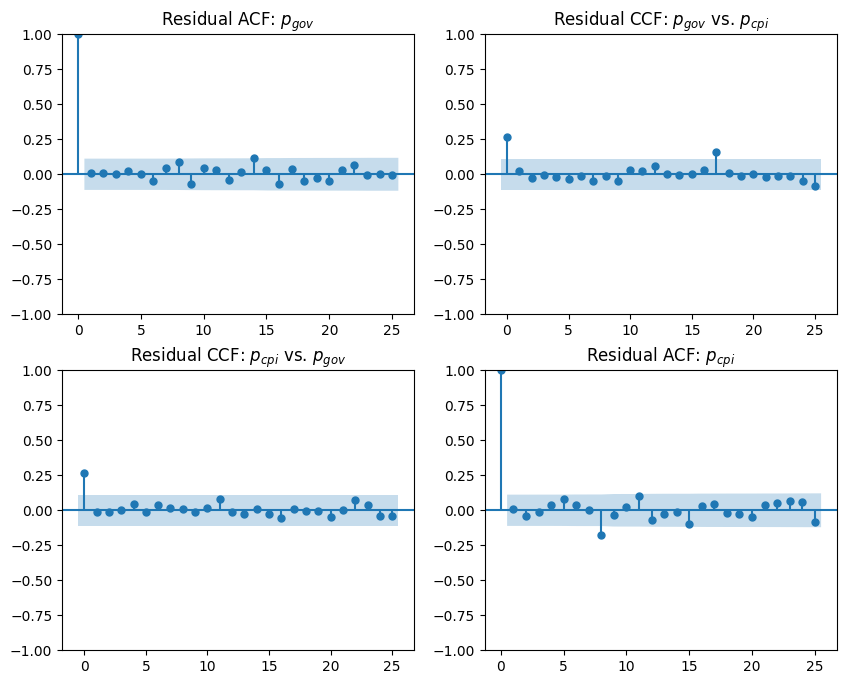

In [ ]:
# acf/ccf plot for CPI
fig = acf_plot(model_cpi,["$p_{gov}$","$p_{cpi}$"])
# fig.savefig("acf-ccf gov-cpi.png")
None

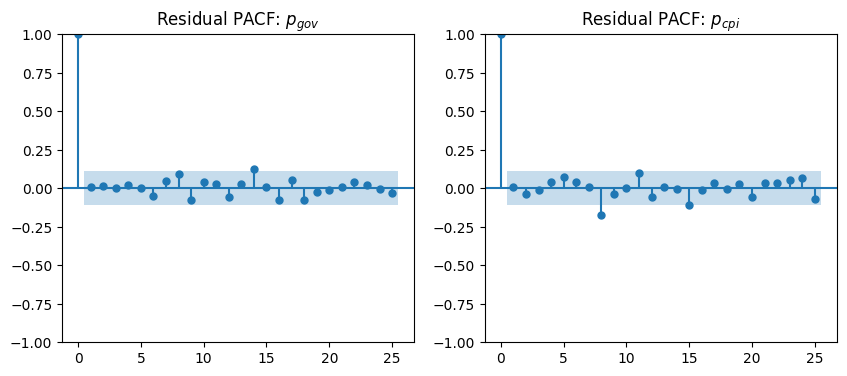

In [ ]:
# pacf plot for cpi
fig = pacf_plot(model_cpi, ["$p_{gov}$","$p_{cpi}$"])
# fig.savefig("pacf gov-cpi.png")
None

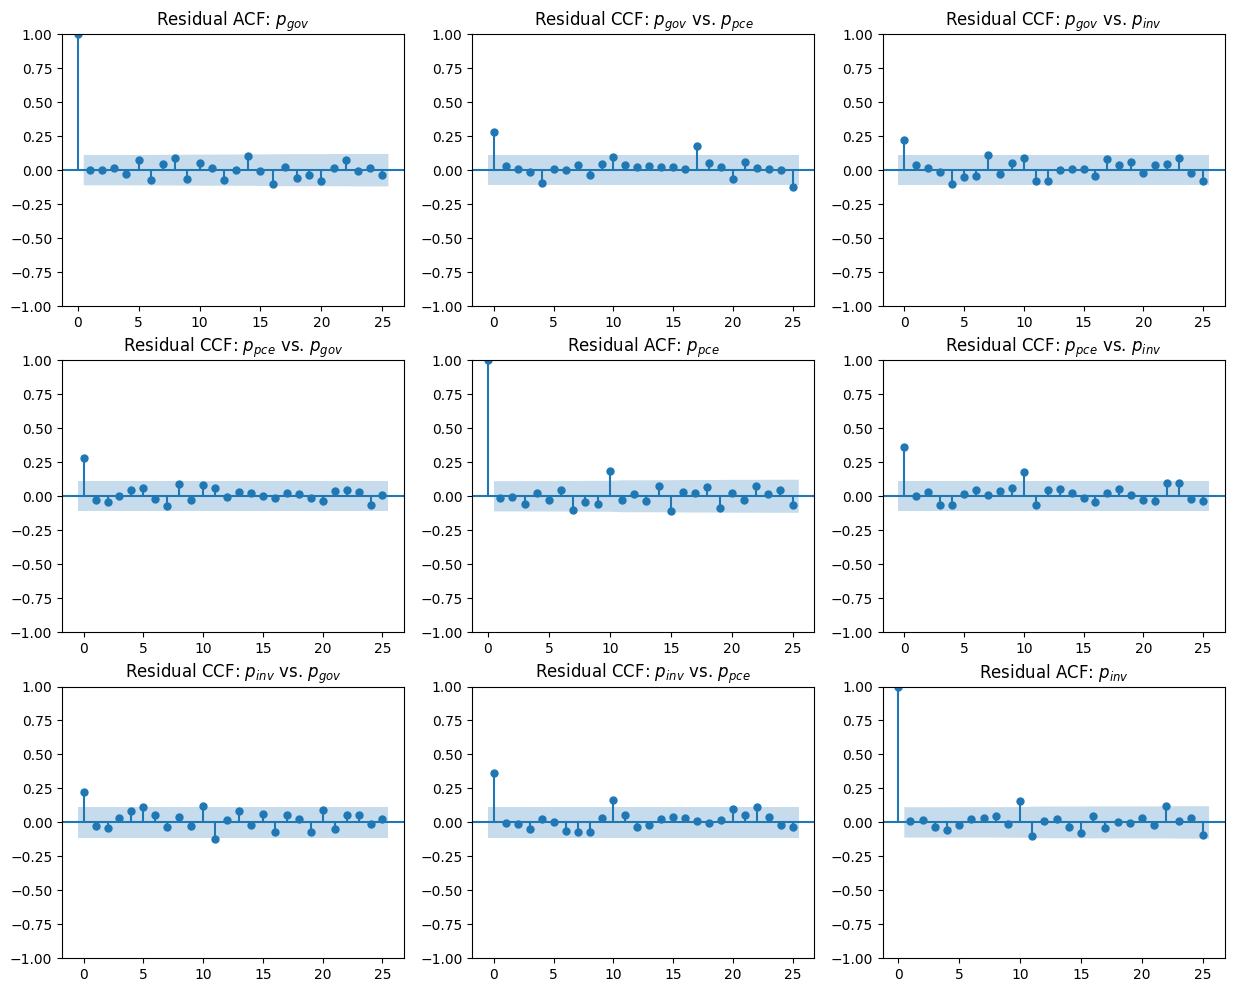

In [ ]:
# acf/ccf plot for nipa
fig = acf_plot(model_nipa,["$p_{gov}$","$p_{pce}$","$p_{inv}$"])
# fig.savefig("acf-ccf nipa.png")
None

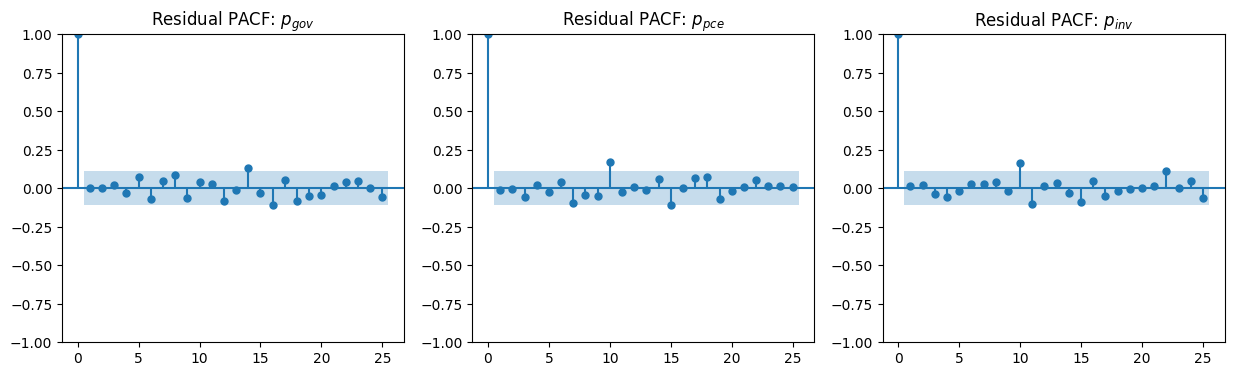

In [176]:
# pacf plot for nipa
fig = pacf_plot(model_nipa, ["$p_{gov}$","$p_{pce}$","$p_{inv}$"])
fig.savefig("pacf nipa.png")
None

## Alternate lag specifications

In [158]:
results = pd.DataFrame(columns=["Lags",r"\thead{$\alpha_{gov}$  \\ significant?}",r"\thead{$\alpha_{cpi}$ \\ significant?}",r"$\alpha_{cpi} / \alpha_{gov}$"])
for i in range(21):
    model = VECM(data_cpi,deterministic="co",k_ar_diff=i).fit()
    results = pd.concat([results, pd.DataFrame({"Lags":i,r"\thead{$\alpha_{gov}$  \\ significant?}":True if model.pvalues_alpha[0] < 0.05 else "\\textbf{False}",r"\thead{$\alpha_{cpi}$ \\ significant?}":model.pvalues_alpha[1] < 0.05,r"$\alpha_{cpi} / \alpha_{gov}$":np.round(model.alpha[1]/model.alpha[0],2)},index=[i])])

# results
caption = r"Tests of the GOV/CPI model with alternate choices for lags. The first two columns indicate whether the loading coefficients are statistically significant at the 5\% level. The third column is the cpi coefficient divided by gov coefficient. The strong form predicts that $\alpha_{gov}$ should not be significant, or at least smaller than $\alpha_{cpi}$."
label="r_govcpilags"
tex = results.to_latex(float_format="%.2f",index=False,column_format="cccc")
print(
    "\\begin{table}\n"
    + "\\centering"
    + tex
    + f"\\caption{{{caption}}}\n"
    + f"\\label{{{label}}}\n"
    +"\\end{table}"
)

\begin{table}
\centering\begin{tabular}{cccc}
\toprule
Lags & \thead{$\alpha_{gov}$  \\ significant?} & \thead{$\alpha_{cpi}$ \\ significant?} & $\alpha_{cpi} / \alpha_{gov}$ \\
\midrule
0 & True & True & 1.21 \\
1 & True & True & 0.95 \\
2 & True & True & 1.22 \\
3 & True & True & 2.01 \\
4 & \textbf{False} & True & 6.05 \\
5 & \textbf{False} & True & 36.67 \\
6 & \textbf{False} & True & 5.65 \\
7 & \textbf{False} & True & 5.56 \\
8 & \textbf{False} & True & 14.56 \\
9 & \textbf{False} & True & 4.21 \\
10 & \textbf{False} & True & 4.68 \\
11 & \textbf{False} & True & 14.18 \\
12 & \textbf{False} & True & 5.94 \\
13 & \textbf{False} & True & 5.78 \\
14 & \textbf{False} & True & 22.57 \\
15 & \textbf{False} & True & -9.00 \\
16 & \textbf{False} & True & 11.21 \\
17 & \textbf{False} & True & -12.19 \\
18 & \textbf{False} & True & -8.51 \\
19 & \textbf{False} & True & -5.45 \\
20 & \textbf{False} & True & -1.81 \\
\bottomrule
\end{tabular}
\caption{Tests of the GOV/CPI model with alternat

c:\Users\Sam\Documents\Stuff\Programming\Monopoly-money-empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Sam\AppData\Local\Temp\ipykernel_24984\285758370.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({"Lags":i,r"\thead{$\alpha_{gov}$  \\ significant?}":True if model.pvalues_alpha[0] < 0.05 else "\\textbf{False}",r"\thead{$\alpha_{cpi}$ \\ significant?}":model.pvalues_alpha[1] < 0.05,r"$\alpha_{cpi} / \alpha_{gov}$":np.round(model.alpha[1]/model.alpha[0],2)},index=[i])])
c:\Users\Sam\Documents\Stuff\Programming\Monopoly-money-empirical

In [161]:
results = pd.DataFrame(columns=["Lags",r"\thead{$\alpha_{gov}$  \\ significant?}",r"\thead{$\alpha_{pce}$ \\ significant?}",r"\thead{$\alpha_{inv}$ \\ significant?}",r"$\alpha$ ratio, pce",r"$\alpha$ ratio, inv"])
for i in range(21):
    model = VECM(data_nipa,deterministic="co",k_ar_diff=i,coint_rank=1).fit()
    results = pd.concat([results, pd.DataFrame({"Lags":i,r"\thead{$\alpha_{gov}$  \\ significant?}": True if model.pvalues_alpha[0] < 0.05 else "\\textbf{False}",r"\thead{$\alpha_{pce}$ \\ significant?}":model.pvalues_alpha[1] < 0.05,r"\thead{$\alpha_{inv}$ \\ significant?}":model.pvalues_alpha[2] < 0.05,r"$\alpha$ ratio, pce":np.round(model.alpha[1]/model.alpha[0],2),r"$\alpha$ ratio, inv":np.round(model.alpha[2]/model.alpha[0],2)},index=[i])])

# results
tex = results.to_latex(float_format="%.2f",index=False,column_format="cccccc")
caption = r"Tests of the NIPA model with alternate choices for lags. The first three columns indicate whether the loading coefficients are statistically significant at the 5\% level. The next columns are the private coefficients divided by the gov coefficient. All models have one cointegrating relationship. The theory predicts that $\alpha_{gov}$ should not be statistically significant, or should at least be smaller than either $\alpha_{pce}$ or $\alpha_{inv}$"
label="r_nipalags"
print(
    "\\begin{table}\n"
    + "\\centering"
    + tex
    + f"\\caption{{{caption}}}\n"
    + f"\\label{{{label}}}\n"
    + "\\end{table}"
)

\begin{table}
\centering\begin{tabular}{cccccc}
\toprule
Lags & \thead{$\alpha_{gov}$  \\ significant?} & \thead{$\alpha_{pce}$ \\ significant?} & \thead{$\alpha_{inv}$ \\ significant?} & $\alpha$ ratio, pce & $\alpha$ ratio, inv \\
\midrule
0 & True & True & True & 1.09 & 1.04 \\
1 & True & True & False & 1.05 & -0.10 \\
2 & \textbf{False} & True & False & 2.90 & -1.13 \\
3 & \textbf{False} & True & True & -2.95 & 2.72 \\
4 & \textbf{False} & True & False & -2.63 & 1.10 \\
5 & \textbf{False} & True & False & -1.33 & 0.66 \\
6 & \textbf{False} & True & False & -2.02 & 0.79 \\
7 & \textbf{False} & True & False & -2.09 & 0.46 \\
8 & \textbf{False} & True & False & -2.12 & 0.16 \\
9 & \textbf{False} & True & False & -3.37 & 0.39 \\
10 & \textbf{False} & True & False & -2.50 & 1.23 \\
11 & \textbf{False} & True & False & -1.47 & 0.53 \\
12 & \textbf{False} & True & False & -2.79 & -0.60 \\
13 & \textbf{False} & True & False & -2.24 & 0.12 \\
14 & \textbf{False} & True & False & -1.24 & 0.2

c:\Users\Sam\Documents\Stuff\Programming\Monopoly-money-empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Sam\AppData\Local\Temp\ipykernel_24984\903691552.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({"Lags":i,r"\thead{$\alpha_{gov}$  \\ significant?}": True if model.pvalues_alpha[0] < 0.05 else "\\textbf{False}",r"\thead{$\alpha_{pce}$ \\ significant?}":model.pvalues_alpha[1] < 0.05,r"\thead{$\alpha_{inv}$ \\ significant?}":model.pvalues_alpha[2] < 0.05,r"$\alpha$ ratio, pce":np.round(model.alpha[1]/model.alpha[0],2),r"$\alpha$ ratio

## Structural break in 1981

In [ ]:
def test_structural_break(data,year,lags,coint=1):
    model_u = VECM(data,deterministic="co",k_ar_diff=lags, coint_rank=coint).fit()
    model_r1 = VECM(data[:year],deterministic="co",k_ar_diff=lags, coint_rank=coint).fit()
    model_r2 = VECM(data[year:],deterministic="co",k_ar_diff=lags, coint_rank=coint).fit()

    test_stat = 2*(model_r1.llf + model_r2.llf - model_u.llf)

    neqs = data.shape[1]
    df = coint * (neqs - coint) + coint * neqs + lags * (neqs**2)
    
    from scipy.stats import chi2
    p_value = 1 - chi2(df).cdf(test_stat)
    crit = chi2(df).ppf(.95)

    return pd.Series({
        "Test for break at":year,
        "Degrees of Freedom": df,
        "Test Statistic": test_stat,
        "Critical value (5\\% level)":crit,
        "p-value":p_value
    }),{
        "unrestricted":model_u,
        "restricted 1":model_r1,
        "restricted 2":model_r2
    }


In [ ]:
# Chow test for structural break, both models
year = str(1981)
test_result1, models1 = test_structural_break(data_cpi,year,lags=5)
test_result2, models2 = test_structural_break(data_nipa,year,lags=4)
caption = "Likelihood ratio (Chow) test for structural break, on GOV/CPI model. \\texttt{statsmodels} does not have an automatic VECM chow test, so this was manually implemented as a likelihood ratio test using a standard $\\chi^2$ distribution."
label = "r_chow"
tex = pd.DataFrame({"GOV/CPI":test_result1,"NIPA":test_result2}).to_latex(float_format="%.3f",column_format="lcc")
print(
    "\\begin{table}\n"
    + "\\centering"
    + tex
    + "\\caption{" + caption + "}\n"
    + "\\label{" + label + "}\n"
    + "\\end{table}"
)



\begin{table}
\centering\begin{tabular}{lcc}
\toprule
 & GOV/CPI & NIPA \\
\midrule
Test for break at & 1981 & 1981 \\
Degrees of Freedom & 23 & 41 \\
Test Statistic & 149.745 & 245.338 \\
Critical value (5\% level) & 35.172 & 56.942 \\
p-value & 0.000 & 0.000 \\
\bottomrule
\end{tabular}
\caption{Likelihood ratio (Chow) test for structural break, on GOV/CPI model. \texttt{statsmodels} does not have an automatic VECM chow test, so this was manually implemented as a likelihood ratio test using a standard $\chi^2$ distribution.}
\label{r_chow}
\end{table}


c:\Users\Sam\Documents\Stuff\Programming\Monopoly-money-empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\Sam\Documents\Stuff\Programming\Monopoly-money-empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\Sam\Documents\Stuff\Programming\Monopoly-money-empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\Sam\Documents\Stuff\Programming\Monopoly-money-empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  se

In [ ]:
# GOV/CPI early model
vecm_alpha_summary_latex(
    models1["restricted 1"],
    ["$\\alpha_{gov}$ for 1947-1981","$\\alpha_{cpi}$ for 1947-1981","Cointegration for 1947-1981"],
    "break_cpi_1_alpha",
    "Loading coefficients for GOV/CPI, 1947 to 1981"
)

\begin{table}
 \centering
 \begin{tabular}{lcccccc}
\multicolumn{7}{c}{\textbf{$\alpha_{gov}$ for 1947-1981}} \\
\toprule
             & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{ec1} &       0.0037  &        0.005     &     0.738  &         0.461        &       -0.006    &        0.013     \\
\bottomrule
\end{tabular}
%\caption{Loading coefficients (alpha) for equation gov}
\\[1em] \begin{tabular}{lcccccc}
\multicolumn{7}{c}{\textbf{$\alpha_{cpi}$ for 1947-1981}} \\
\toprule
             & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{ec1} &       0.0102  &        0.003     &     3.380  &         0.001        &        0.004    &        0.016     \\
\bottomrule
\end{tabular}
%\caption{Loading coefficients (alpha) for equation cpi}
\\[1em] \begin{tabular}{lcccccc}
\multicolumn{7}{c}{\textbf{Cointegration for 1947-1981}} \\
\top

In [ ]:
# GOV/CPI late model
vecm_alpha_summary_latex(
    models1["restricted 2"],
    ["$\\alpha_{gov}$ for 1981-2025","$\\alpha_{cpi}$ for 1981-2025","Cointegration for 1981-2025"],
    "break_cpi_2_alpha",
    "Loading coefficients for GOV/CPI, 1981 to 2025"
)

\begin{table}
 \centering
 \begin{tabular}{lcccccc}
\multicolumn{7}{c}{\textbf{$\alpha_{gov}$ for 1981-2025}} \\
\toprule
             & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{ec1} &      -0.0127  &        0.008     &    -1.564  &         0.118        &       -0.029    &        0.003     \\
\bottomrule
\end{tabular}
%\caption{Loading coefficients (alpha) for equation gov}
\\[1em] \begin{tabular}{lcccccc}
\multicolumn{7}{c}{\textbf{$\alpha_{cpi}$ for 1981-2025}} \\
\toprule
             & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{ec1} &       0.0194  &        0.011     &     1.819  &         0.069        &       -0.002    &        0.040     \\
\bottomrule
\end{tabular}
%\caption{Loading coefficients (alpha) for equation cpi}
\\[1em] \begin{tabular}{lcccccc}
\multicolumn{7}{c}{\textbf{Cointegration for 1981-2025}} \\
\top

In [ ]:
# NIPA early model
vecm_alpha_summary_latex(
    models2["restricted 1"],
    ["$\\alpha_{gov}$ for 1947-1981","$\\alpha_{pce}$ for 1947-1981","$\\alpha_{inv}$ for 1947-1981","Cointegration for 1947-1981"],
    "break_nipa_1_alpha",
    "Loading coefficients for NIPA model, 1947 to 1981"
)

\begin{table}
 \centering
 \begin{tabular}{lcccccc}
\multicolumn{7}{c}{\textbf{$\alpha_{gov}$ for 1947-1981}} \\
\toprule
             & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{ec1} &       0.0137  &        0.011     &     1.289  &         0.197        &       -0.007    &        0.035     \\
\bottomrule
\end{tabular}
%\caption{Loading coefficients (alpha) for equation gov}
\\[1em] \begin{tabular}{lcccccc}
\multicolumn{7}{c}{\textbf{$\alpha_{pce}$ for 1947-1981}} \\
\toprule
             & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{ec1} &       0.0222  &        0.005     &     4.626  &         0.000        &        0.013    &        0.032     \\
\bottomrule
\end{tabular}
%\caption{Loading coefficients (alpha) for equation pce}
\\[1em] \begin{tabular}{lcccccc}
\multicolumn{7}{c}{\textbf{$\alpha_{inv}$ for 1947-1981}} \\
\to

In [ ]:
# NIPA late model
vecm_alpha_summary_latex(
    models2["restricted 2"],
    ["$\\alpha_{gov}$ for 1981-2025","$\\alpha_{pce}$ for 1981-2025","$\\alpha_{inv}$ for 1981-2025","Cointegration for 1981-2025"],
    "break_nipa_2_alpha",
    "Loading coefficients for NIPA, 1981 to 2025"
)

\begin{table}
 \centering
 \begin{tabular}{lcccccc}
\multicolumn{7}{c}{\textbf{$\alpha_{gov}$ for 1981-2025}} \\
\toprule
             & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{ec1} &      -0.0006  &        0.002     &    -0.367  &         0.714        &       -0.004    &        0.003     \\
\bottomrule
\end{tabular}
%\caption{Loading coefficients (alpha) for equation gov}
\\[1em] \begin{tabular}{lcccccc}
\multicolumn{7}{c}{\textbf{$\alpha_{pce}$ for 1981-2025}} \\
\toprule
             & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{ec1} &       0.0045  &        0.001     &     3.514  &         0.000        &        0.002    &        0.007     \\
\bottomrule
\end{tabular}
%\caption{Loading coefficients (alpha) for equation pce}
\\[1em] \begin{tabular}{lcccccc}
\multicolumn{7}{c}{\textbf{$\alpha_{inv}$ for 1981-2025}} \\
\to

## Normality tests

In [ ]:
test_results = {}
for model,model_name in zip([model_cpi,model_nipa],["GOV/CPI","NIPA"]):
    test = model.test_normality()
    test_results[model_name] = pd.Series({
        "Test statistic":test.test_statistic,
        "Critical value":test.crit_value,
        "\\textbf{p-value}":f"\\textbf{{{test.pvalue:.4f}}}",
        "df":test.df,
    })
tex = pd.DataFrame(test_results).to_latex(column_format="ccc",float_format="%.4f")
caption = "Tests for normality using the Jarque-Bera-style omnibus $\\chi^2$ test. A small p-value rejects the null hypothesis of normally-distributed residuals."
label = "r_normality"
print(
    "\\begin{table}\n"
    +"\\centering"
    + tex
    + f"\\caption{{{caption}}}\n"
    + f"\\label{{{label}}}\n"
    "\\end{table}"
)

\begin{table}
\centering\begin{tabular}{ccc}
\toprule
 & GOV/CPI & NIPA \\
\midrule
Test statistic & 321.0498 & 628.7256 \\
Critical value & 9.4877 & 12.5916 \\
\textbf{p-value} & \textbf{0.0000} & \textbf{0.0000} \\
df & 4 & 6 \\
\bottomrule
\end{tabular}
\caption{Tests for normality using the Jarque-Bera-style omnibus $\chi^2$ test. A small p-value rejects the null hypothesis of normally-distributed residuals.}
\label{r_normality}
\end{table}


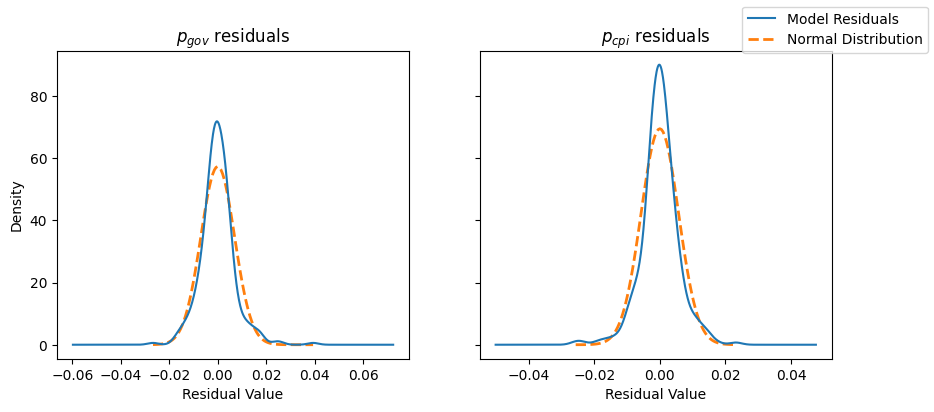

In [ ]:
# residual plots for CPI
bins = 100

from scipy.stats import norm

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)

model = model_cpi
for ax, title,i in zip(axes,['$p_{gov}$ residuals','$p_{cpi}$ residuals'],range(model.neqs)):
    # residual data
    resids = pd.Series(model.resid[:,i])
    resids.plot.density(linestyle="-",ax=ax,label="Model Residuals",zorder=2)
    ax.set_title(title)
    ax.set_xlabel('Residual Value')
    ax.set_ylabel('Density')

    # normal curve
    mean, std = resids.mean(), resids.std()
    x_min, x_max = min(resids), max(resids)
    x = np.linspace(x_min,x_max, bins)
    pdf = norm.pdf(x,mean,std)
    ax.plot(x, pdf, '--', linewidth=2, label='Normal Distribution',zorder=1)

    
fig.legend(*ax.get_legend_handles_labels())
# fig.savefig("cpi_residuals.png")
None


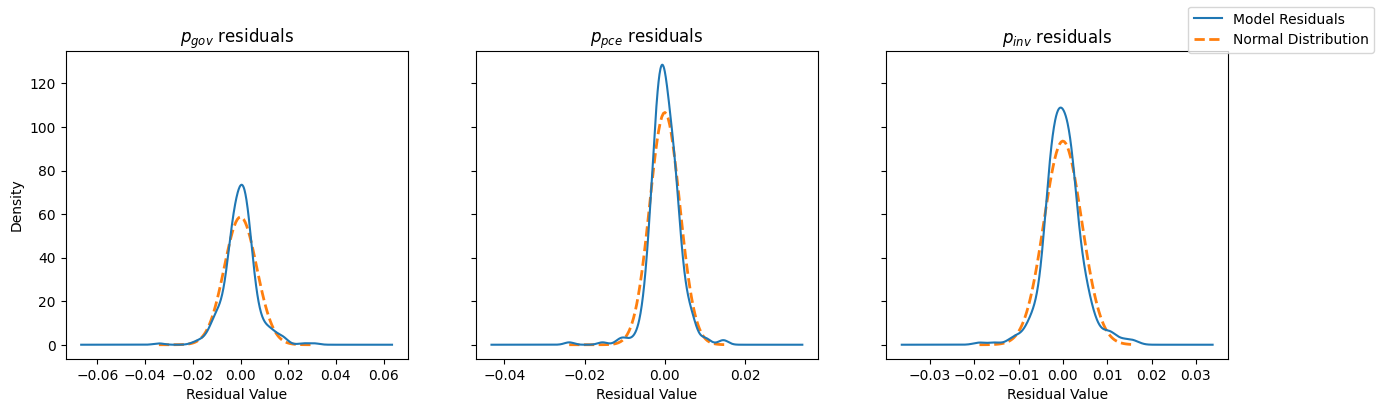

In [ ]:
# residual plots for NIPA
bins = 100

from scipy.stats import norm

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharey=True)

model = model_nipa
for ax, title,i in zip(axes,['$p_{gov}$ residuals','$p_{pce}$ residuals','$p_{inv}$ residuals'],range(model.neqs)):
    # residual data
    resids = pd.Series(model.resid[:,i])
    resids.plot.density(linestyle="-",ax=ax,label="Model Residuals",zorder=2)
    ax.set_title(title)
    ax.set_xlabel('Residual Value')
    ax.set_ylabel('Density')

    # normal curve
    mean, std = resids.mean(), resids.std()
    x_min, x_max = min(resids), max(resids)
    x = np.linspace(x_min,x_max, bins)
    pdf = norm.pdf(x,mean,std)
    ax.plot(x, pdf, '--', linewidth=2, label='Normal Distribution',zorder=1)

    
fig.legend(*ax.get_legend_handles_labels())
# fig.savefig("_residuals.png")
None


## Alternate deterministic specifications

In [165]:
table = pd.DataFrame(columns=["\\thead{$\\alpha_{gov}$ \\\\ significant}","\\thead{$\\alpha_{cpi}$ \\\\ significant}","$\\alpha_{cpi} / \\alpha_{gov}$"])
for det, det_label in zip(["n","co","ci","lo","li","colo","coli","cilo","cili"],
        ["No deterministic terms","Constant outside EC","Constant inside EC","Linear outside EC","Linear inside EC","Constant \\& Linear outside","Constant outside, Linear inside","Constant inside, Linear outside","Constant \\& Linear inside"]
        ):
    model = VECM(data_cpi,deterministic=det,k_ar_diff=5).fit()
    table = pd.concat([table, pd.DataFrame({"\\thead{$\\alpha_{gov}$ \\\\ significant}":True if model.pvalues_alpha[0] < 0.05 else "\\textbf{False}","\\thead{$\\alpha_{cpi}$ \\\\ significant}":model.pvalues_alpha[1] < 0.05, "$\\alpha_{cpi} / \\alpha_{gov}$":model.alpha[1] / model.alpha[0]}, index=[det_label])])
tex = table.to_latex(float_format="%.3f",column_format="cccc")
print(
    "\\begin{table}\n"
    + "\\centering\n"
    + tex
    + "\\caption{Alternate deterministic specifications for the GOV/CPI model. All are run with 5 lagged differences, identically to the base case. Significance tests are at the 5\\% level. 'EC' = Error Correction term}\n"
    + "\\label{cpi_trends}\n"
    + "\\end{table}"
)

\begin{table}
\centering
\begin{tabular}{cccc}
\toprule
 & \thead{$\alpha_{gov}$ \\ significant} & \thead{$\alpha_{cpi}$ \\ significant} & $\alpha_{cpi} / \alpha_{gov}$ \\
\midrule
No deterministic terms & \textbf{False} & True & -0.898 \\
Constant outside EC & \textbf{False} & True & 36.665 \\
Constant inside EC & \textbf{False} & True & 2.035 \\
Linear outside EC & True & True & 1.253 \\
Linear inside EC & True & True & 1.329 \\
Constant \& Linear outside & \textbf{False} & True & -39.445 \\
Constant outside, Linear inside & \textbf{False} & True & -3.824 \\
Constant inside, Linear outside & True & True & 1.574 \\
Constant \& Linear inside & True & True & 1.513 \\
\bottomrule
\end{tabular}
\caption{Alternate deterministic specifications for the GOV/CPI model. All are run with 5 lagged differences, identically to the base case. Significance tests are at the 5\% level. 'EC' = Error Correction term}
\label{cpi_trends}
\end{table}


c:\Users\Sam\Documents\Stuff\Programming\Monopoly-money-empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Sam\AppData\Local\Temp\ipykernel_24984\1222222877.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame({"\\thead{$\\alpha_{gov}$ \\\\ significant}":True if model.pvalues_alpha[0] < 0.05 else "\\textbf{False}","\\thead{$\\alpha_{cpi}$ \\\\ significant}":model.pvalues_alpha[1] < 0.05, "$\\alpha_{cpi} / \\alpha_{gov}$":model.alpha[1] / model.alpha[0]}, index=[det_label])])
c:\Users\Sam\Documents\Stuff\Programming\Monopoly-money-empirical\.venv\L

In [167]:
table = pd.DataFrame(columns=["\\thead{$\\alpha_{gov}$ \\\\ significant}","\\thead{$\\alpha_{pce}$ \\\\ significant}","\\thead{$\\alpha_{inv}$ \\\\ significant}","$\\alpha_{pce} / \\alpha_{gov}$","$\\alpha_{inv} / \\alpha_{gov}$"])
for det, det_label in zip(["n","co","ci","lo","li","colo","coli","cilo","cili"],
        ["No deterministic terms","Constant outside EC","Constant inside EC","Linear outside EC","Linear inside EC","Constant \\& Linear outside","Constant outside, Linear inside","Constant inside, Linear outside","Constant \\& Linear inside"]
        ):
    model = VECM(data_nipa,deterministic=det,k_ar_diff=4).fit()
    table = pd.concat([table, pd.DataFrame({
        "\\thead{$\\alpha_{gov}$ \\\\ significant}":True if model.pvalues_alpha[0] < 0.05 else "\\textbf{False}",
        "\\thead{$\\alpha_{pce}$ \\\\ significant}":model.pvalues_alpha[1] < 0.05, 
        "\\thead{$\\alpha_{inv}$ \\\\ significant}":model.pvalues_alpha[2] < 0.05, 
        "$\\alpha_{pce} / \\alpha_{gov}$":model.alpha[1] / model.alpha[0],
        "$\\alpha_{inv} / \\alpha_{gov}$":model.alpha[2] / model.alpha[0],
        }, index=[det_label])])
tex = table.to_latex(float_format="%.3f",column_format="cccccc")
print(
    "\\begin{table}\n"
    + "\\centering\n"
    + tex
    + "\\caption{Alternate deterministic specifications for the NIPA model. All are run with 4 lagged differences, identically to the base case. Significance tests are at the 5\\% level. 'EC' = Error Correction term.}\n"
    + "\\label{nipa_trends}\n"
    + "\\end{table}"
)

\begin{table}
\centering
\begin{tabular}{cccccc}
\toprule
 & \thead{$\alpha_{gov}$ \\ significant} & \thead{$\alpha_{pce}$ \\ significant} & \thead{$\alpha_{inv}$ \\ significant} & $\alpha_{pce} / \alpha_{gov}$ & $\alpha_{inv} / \alpha_{gov}$ \\
\midrule
No deterministic terms & True & False & True & -0.083 & 0.877 \\
Constant outside EC & \textbf{False} & True & False & -2.631 & 1.101 \\
Constant inside EC & \textbf{False} & True & False & 3.147 & -0.702 \\
Linear outside EC & \textbf{False} & True & False & 6.671 & -1.188 \\
Linear inside EC & \textbf{False} & True & False & 2.594 & -0.692 \\
Constant \& Linear outside & \textbf{False} & True & False & -11.284 & 4.968 \\
Constant outside, Linear inside & \textbf{False} & True & True & -4.489 & 2.689 \\
Constant inside, Linear outside & \textbf{False} & True & False & 4.760 & -1.356 \\
Constant \& Linear inside & \textbf{False} & True & False & 2.195 & -0.798 \\
\bottomrule
\end{tabular}
\caption{Alternate deterministic specifications

c:\Users\Sam\Documents\Stuff\Programming\Monopoly-money-empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Sam\AppData\Local\Temp\ipykernel_24984\2740448276.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame({
c:\Users\Sam\Documents\Stuff\Programming\Monopoly-money-empirical\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\Sam\Documents\Stuff\Programming\Monopoly-money-empirical\.venv\Lib\site-pac

# End